In [7]:
import pandas as pd
import numpy as np
import glob
import laspy
#import open3d as o3d
import cv2

import matplotlib.pyplot as plt

import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from sklearn.model_selection import train_test_split

from PIL import Image

In [8]:
folder_name = ""

#trainloader = torch.load(folder_name+"trainloader.pt")
#valloader = torch.load("valloader.pt")
testloader = torch.load(folder_name+"testloader.pt")

In [9]:
class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
    
    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        return x
    
class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)
        return x, p
    
class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block(out_c+out_c, out_c)
    
    def forward(self, inputs, skip):
        x = self.up(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)
        return x
    
class ConvUNet(nn.Module):
    
    def __init__(self):
        super().__init__()
        #""" Encoder """
        self.e1 = encoder_block(1, 64).cuda()
        self.e2 = encoder_block(64, 128).cuda()
        self.e3 = encoder_block(128, 256).cuda()
        self.e4 = encoder_block(256, 512).cuda()
        #""" Bottleneck """
        self.b = conv_block(512, 1024).cuda()
        #""" Decoder """
        self.d1 = decoder_block(1024, 512).cuda()
        self.d2 = decoder_block(512, 256).cuda()
        self.d3 = decoder_block(256, 128).cuda()
        self.d4 = decoder_block(128, 64).cuda()
        #""" Classifier """
        self.outputs = nn.Conv2d(64, 1, kernel_size=1, padding=0).cuda()
    
    def forward(self, inputs):
        #""" Encoder """
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)

        #""" Bottleneck """
        b = self.b(p4)

        #""" Decoder """
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)

        #""" Classifier """
        outputs = self.outputs(d4)
        return outputs



In [10]:
bestModel = torch.load(folder_name+"bestModel.pth")

In [ ]:
bestModel.eval()
with torch.no_grad():
    for j, data in enumerate(testloader):
        # get the input
        batch_input, batch_labels = data
        
        for i in range(len(batch_labels)):
            
            masked, labels = batch_input[i].unsqueeze(0), batch_labels[i].unsqueeze(0)

            fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(15,10))
            
            ax0.set_title('Masked')
            ax0.imshow(((torch.squeeze(masked.detach())).numpy()),cmap='gray')

            outputs = torch.squeeze(bestModel(masked.cuda())).detach().cpu()
            outputs = (torch.sigmoid(outputs) > 0.5).float()
            
            ax1.set_title('Prediction')
            ax1.imshow(outputs.numpy(),cmap='gray')
            
            ax2.set_title("Label")
            ax2.imshow(((torch.squeeze(labels.detach())).numpy()),cmap='gray')

            ax0.axis('off')
            ax1.axis('off')
            ax2.axis('off')
            plt.show()

amunt of crops: 32
torch.Size([1, 4096, 4096])
(4096, 4096)


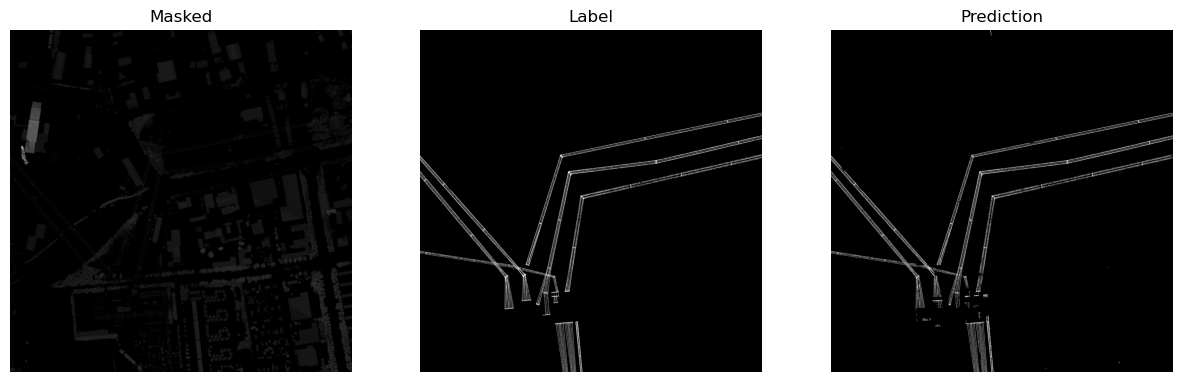

torch.Size([1, 4096, 4096])


KeyboardInterrupt: 

In [11]:
# Patches
network_size = 128
image_size = 4096
amount_of_crops = image_size//network_size
print("amunt of crops:", amount_of_crops)


predictions = []
with torch.no_grad():
    for j, data in enumerate(testloader):
        # get the input
        batch_input, batch_labels = data
        
        for i in range(len(batch_labels)):
            masked, labels = batch_input[i], batch_labels[i]
            #[1, 4096, 4096]
            
            print(masked.shape)
            
            cropped_image_list = []
            for i in range(amount_of_crops):
                x_start_index = network_size*i
                x_end_index = network_size*(i+1)
                
                for j in range(amount_of_crops):
                    # Generate slice indices
                    y_start_index = network_size*j
                    y_end_index = network_size*(j+1)
                    
                    # Apply slice mask and obtain the cropped image
                    cropped_image = masked[0][x_start_index:x_end_index,y_start_index:y_end_index]
                    cropped_image_list.append(cropped_image.unsqueeze(0).unsqueeze(0))
            
            output_list = []
            for img in cropped_image_list:
                outputs = torch.squeeze(bestModel(img.cuda())).detach().cpu()
                
                #outputs = torch.sigmoid(outputs)
                outputs = (torch.sigmoid(outputs) >= 0.5).float()
                output_list.append(outputs)
            
            row_images = []
            for i in range(amount_of_crops):
                # to obtain each row in an image
                row_to_concat = output_list[(i)*amount_of_crops:(i+1)*amount_of_crops]
                stacked_array = np.concatenate([arr for arr in row_to_concat], axis=1)
                row_images.append(stacked_array)
                
            predicted_labels = np.concatenate([arr for arr in row_images], axis=0)
            print(predicted_labels.shape)

            fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(15,10))

            ax0.set_title('Masked')
            ax0.imshow(masked[0].numpy(),cmap='gray')
            
            ax1.set_title('Label')
            ax1.imshow(labels[0].numpy(),cmap='gray')

            ax2.set_title('Prediction')
            ax2.imshow(predicted_labels, cmap='gray')            

            ax0.axis('off')
            ax1.axis('off')
            ax2.axis('off')
            plt.show()